# Exercises 1

Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using `tf.keras.applications.EfficientNetB0` as the base model. Use the `ModelCheckpoint` callback to save the weights to file.

In [65]:
# Import necessary libraries
import os
import datetime
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

print(tf.__version__)

2.12.0


## Import data and explore it

In [4]:
# Get some data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2023-07-11 14:41:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.11.128, 142.251.162.128, 74.125.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.11.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   162MB/s    in 1.0s    

2023-07-11 14:41:05 (162 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# How many directory and image we have?
for dir in os.walk('10_food_classes_10_percent'):
    print(f"There are {len(dir[1])} directories and {len(dir[2])} images in '{dir[0]}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/train'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_crea

## Set data loader

In [6]:
# Creating train and test directory paths
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

In [7]:
# Set global variables
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Set data loader
print('Train data: ')
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 label_mode='categorical',
                                                                 image_size=IMAGE_SIZE,
                                                                 batch_size=BATCH_SIZE)
print('\n')

print('Test data: ')
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMAGE_SIZE,
                                                                batch_size=BATCH_SIZE)

Train data: 
Found 750 files belonging to 10 classes.


Test data: 
Found 2500 files belonging to 10 classes.


In [8]:
# Check the train batch dataset
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# How many classes we have?
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Data Augmentation

In [10]:
# Create data augmentation
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip('horizontal_and_vertical'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
])

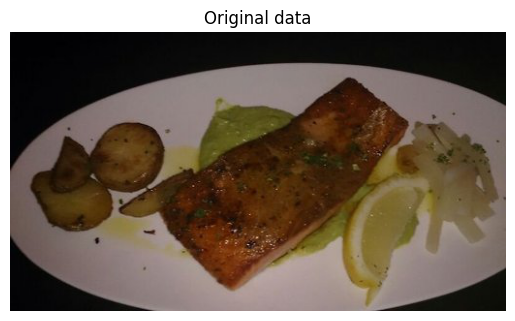

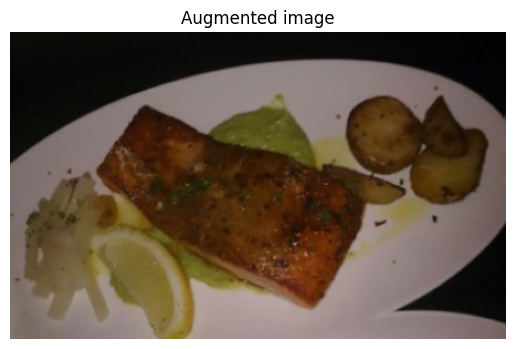

In [45]:
# View a random image and compare it with data augmented version
target_class = random.choice(train_data.class_names)
target_dir = '10_food_classes_10_percent/test/' + target_class
random_image = target_dir + '/' + random.choice(os.listdir(target_dir))

# Plot the original image
img = mpimg.imread(random_image)
plt.imshow(img)
plt.title('Original data')
plt.axis(False)
plt.show()

# Plot the augmented image
augmented_image = data_augmentation(img)
plt.imshow(augmented_image/255.)
plt.title('Augmented image')
plt.axis(False)
plt.show()

## ModelCheckpoint

In [46]:
# Set a checkpoint path
checkpoint_path = 'check_point_directory/checkpoint.ckpt'

# Create a checkpoint that saves only weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         verbose=1,
                                                         save_freq='epoch',
                                                         save_best_only=False,
                                                         save_weights_only=True)

## Create a model

In [57]:
# Set the input shape and base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

In [61]:
# Create the input layer
inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')

# Add data augmentation in model as a layer
x = data_augmentation(inputs)

# Give base_model the input and dont train it
x = base_model(x, training=False)

# Pool output feature ıf the output model
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# Put a dense layer as the output layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# Make a model using the inputs and outputs
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# Fit the model
model_1_history = model_1.fit(train_data,
                              epochs=10,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=int(0.25*len(test_data)),
                              callbacks=[checkpoint_callback])

Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 2.0029 - accuracy: 0.3133
Epoch 1: saving model to check_point_directory/checkpoint.ckpt
24/24 [==============================] - 24s 653ms/step - loss: 2.0029 - accuracy: 0.3133 - val_loss: 1.4905 - val_accuracy: 0.6595
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.3545 - accuracy: 0.6707
Epoch 2: saving model to check_point_directory/checkpoint.ckpt
24/24 [==============================] - 13s 512ms/step - loss: 1.3545 - accuracy: 0.6707 - val_loss: 1.0377 - val_accuracy: 0.7928
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 1.0738 - accuracy: 0.7373
Epoch 3: saving model to check_point_directory/checkpoint.ckpt
24/24 [==============================] - 12s 434ms/step - loss: 1.0738 - accuracy: 0.7373 - val_loss: 0.8203 - val_accuracy: 0.8207
Epoch 4/10
24/24 [==============================] - ETA: 0s - loss: 0.9013 - accuracy: 0.7773
Epoch 4: saving model to check_point_di

## Evaluate the model

In [63]:
# Check out the plot loss curves
def plot_loss_curves(history):

    '''
    Plot the loss and accuracy curves for training and validation parts.

    Args:
        history: TensorFlow history object.
    Returns:
        Loss and accuracy curves for training and validation
    '''

    # Convert history to dataframe
    dataframe = pd.DataFrame(history.history)
    dataframe = dataframe.set_index(pd.Index(range(1, len(dataframe) + 1)))

    # Set the plot size
    plt.figure(figsize=(12, 5))

    # Plot train and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(dataframe['loss'], 'b', label='Train loss')
    plt.plot(dataframe['val_loss'], 'r', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    # Plot train and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(dataframe['accuracy'], 'b', label='Train accuracy')
    plt.plot(dataframe['val_accuracy'], 'r', label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()

    # Adjust spaces and plot
    plt.subplots_adjust(wspace=0.3)
    plt.show()

In [62]:
# Evaluate the model
model_1.evaluate(test_data)

79/79 [==============================] - 7s 82ms/step - loss: 0.5290 - accuracy: 0.8504


[0.5289866328239441, 0.8503999710083008]

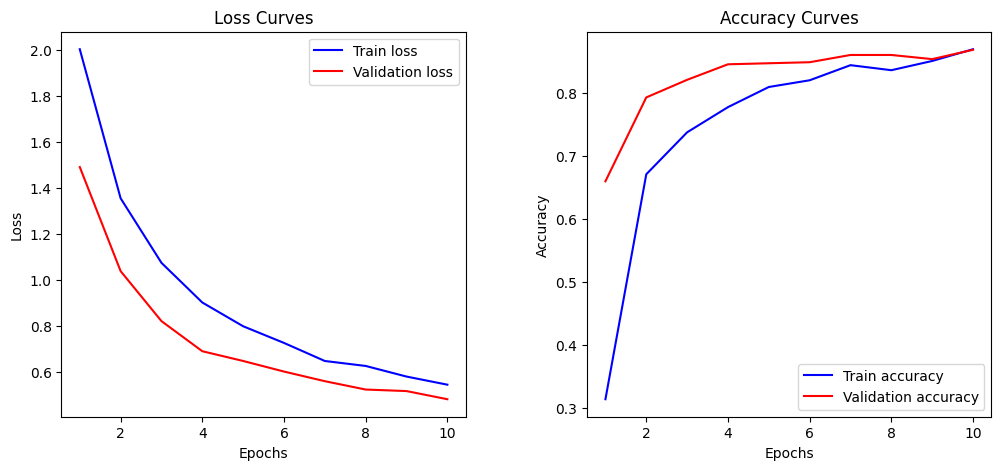

In [68]:
# Plot the loss curves
plot_loss_curves(model_1_history)